This notebook contains the python codes to produce Figure 1 in the paper. 

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random  
import matplotlib.colors as mcolors
import matplotlib.cm as cm

In [2]:
sns.set()

import warnings

def fxn():
    warnings.warn("deprecated", DeprecationWarning)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()

warnings.filterwarnings("ignore")

In what follows, $\mu$ will stand for the uniform distribution on the unit hypercube. 

The next cell considers the choice of $\nu$, the distribution of interest

In [ ]:
from scipy.stats import beta

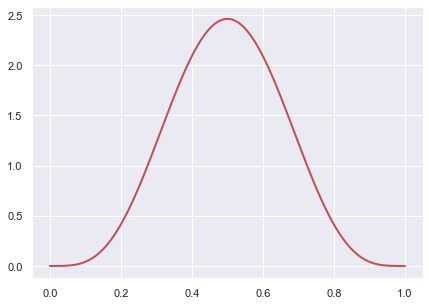

In [14]:
plt.figure(figsize=(7,5))
a, b = 5, 5

z = np.linspace(beta.ppf(0, a, b), beta.ppf(1, a, b), 1000)
plt.plot(z, beta.pdf(z, a, b),'r-', lw=2, label='Densité de la loi beta')

plt.savefig('Figures/fid_1d_density_beta.eps',bbox_inches='tight')

The next cell vizualises the true quantile function of the beta distribution. Knowing this true quantile function, the true dual optimal can be retrieved by the relation
$$
Q(x) = \nabla\left(\frac{1}{2}x^2 - u(x)\right).
$$

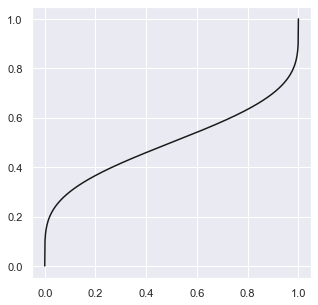

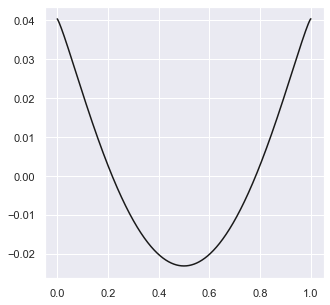

In [5]:

# Choice of a regular grid of quantile levels
nb_pts = 1000
grid_x = np.linspace(0,1,nb_pts)

# Quantile function
T0 = beta.ppf(grid_x, a, b)

plt.figure(figsize=(5,5))
plt.plot(grid_x,T0,'k')

# Optimal dual vector
u0 = grid_x**2/2-np.cumsum(T0)/len(grid_x)
u0 = u0-np.mean(u0)

plt.figure(figsize=(5,5))
plt.plot(grid_x,u0,'k')

After that, we aim to implement our FFT-based procedure to approach these quantiles. First we define the necessary functions. 

In [6]:
choix_cost = 1 # 0 = choice of the quadratic cost ; 1 = torus cost

def cost(x,Y):
    """
    Squared euclidean distance between x and the J points of Y.
    if x is the ith point of the support of the distribution, 
    the result is the ith line of the cost matrix.
    
    """
    if (choix_cost == 0):
        return(0.5*(Y-x)**2)
    else:
        return(0.5*np.min([np.sqrt((Y-x)**2),1-np.sqrt((Y-x)**2)],axis=0)**2)
    

def c_transform_fft(u, grid_unif, y, eps=0.1):
    """Calculate the c_transform of u"""
    arg = (u - cost(grid_unif, y))/eps
    to_sum = np.exp(arg)
    return(-eps*np.log(np.mean(to_sum)))
    
def grad_heps_fft(u, grid_unif, y, eps=0.1):
    """
    Calculate the gradient h_eps 
    """

    F_u = np.exp((u - cost(grid_unif, y))/eps)
    argD = np.mean(F_u)
    grad = -np.fft.fft(F_u)/argD

    return(grad)

def h_eps_fft(u, grid_unif, y, eps=0.1):
    """
    Calculate the function h_eps whose expectation equals H_eps.
    """
    return(c_transform_fft(u, grid_unif, y, eps)-eps)

def Robbins_Monro_Algo_fft(grid_unif, Y, eps=0.1, gamma= 1, c = 3/4, alpha= 0, epoch = 1):   
    p = len(grid_unif)
    n_iter = len(Y)*epoch
    
    # Sample the observations from Y for the upcoming iterations
    sample = np.random.choice(a=np.arange(len(Y)), size=n_iter)
    
    # Choice of the matrix W
    N = len(grid_unif)
    freqs = np.fft.fftfreq(N)
    freqs[0] = 1/N
    W = 1/(N*np.abs(freqs))**alpha
 
    # Storage of the recursive estimators
    W_hat_storage = np.zeros(n_iter)
    h_eps_storage = np.zeros(n_iter)
    u_storage = np.zeros((n_iter,p))

    # Initialisation of the vector u
    u = np.zeros(p)
    fft_u = np.fft.fft(u)
    
    # First iteration.
    y_0 = Y[sample[0]] 
    W_hat_storage[0] = h_eps_fft(u, grid_unif, y_0, eps)
    h_eps_storage[0] = h_eps_fft(u, grid_unif, y_0, eps)

    # Robbins Monro scheme.
    for k in range(1,n_iter):

        # sample y from nu
        y = Y[sample[k]]
        
        # iterate fft_u and centering the integral of the corresponding function
        u = np.real(np.fft.ifft(fft_u))
        fft_u = fft_u + gamma/((k+1)**c) * W * grad_heps_fft(u, grid_unif, y, eps)
        fft_u[0] = 0
        
        # Storage of h_eps at point (u,y).
        h_eps_storage[k] = h_eps_fft(u, grid_unif, y, eps)
    
        # Approximation of the Sinkhorn divergence
        W_hat_storage[k] = k/(k+1) * W_hat_storage[k-1] + 1/(k+1) * h_eps_storage[k]
        
        # Storage of u at each iteration
        u = u-np.mean(u)
        u_storage[k,:] = u 
    
    L = [u_storage, W_hat_storage]
    
    return(L)


### We first consider the torus cost

In [22]:
choix_cost = 1

The next cell implements the computation of our algorithm for a grid of values for $\epsilon$, and for the torus cost.

In [23]:
# Fixing the randomness :
random.seed(1)

# Grid for epsilon
nb_eps = 20
grid_eps = np.round(np.linspace(0.005,0.5,nb_eps),3)

# Number of iterations
n = 10**5

# Simulation of the data 
Y = beta.rvs(a, b, size=n)

hat_Teps = np.zeros([nb_eps,nb_pts])
hat_ueps = np.zeros([nb_eps,nb_pts])
hat_Weps = np.zeros([nb_eps,n])

freqs = np.fft.fftfreq(nb_pts)
    
for m_eps in range(0,nb_eps):
    
    # Choice of the regularization
    eps = grid_eps[m_eps]
    
    print('Epsilon = ', end='')
    print('{} - '.format(eps), end='')
        
    # Learning rate depending on epsilon
    gamma = eps
        
    # Compute the regularized maps by RM-FTT
    res_RM_fft = Robbins_Monro_Algo_fft(grid_x, Y, eps=eps, gamma = gamma, c = 3/4, alpha = 2, epoch = 1)
    hat_u = res_RM_fft[0][n-1]
    hat_W = res_RM_fft[1]

    hat_u_fft =np.fft.fft(hat_u)
    hat_T = grid_x - np.real(np.fft.ifft(2*np.pi*1j*freqs*hat_u_fft))/(grid_x[1]-grid_x[0])
        
    # Store the results
    hat_Teps[m_eps,:] = hat_T
    hat_ueps[m_eps,:] = hat_u 
    hat_Weps[m_eps,:] = hat_W

print(' Fin des itérations', end='\n')

Epsilon = 0.005 - Epsilon = 0.031 - Epsilon = 0.057 - Epsilon = 0.083 - Epsilon = 0.109 - Epsilon = 0.135 - Epsilon = 0.161 - Epsilon = 0.187 - Epsilon = 0.213 - Epsilon = 0.239 - Epsilon = 0.266 - Epsilon = 0.292 - Epsilon = 0.318 - Epsilon = 0.344 - Epsilon = 0.37 - Epsilon = 0.396 - Epsilon = 0.422 - Epsilon = 0.448 - Epsilon = 0.474 - Epsilon = 0.5 -  Fin des itérations


The next cell plots the results of the previous cell.

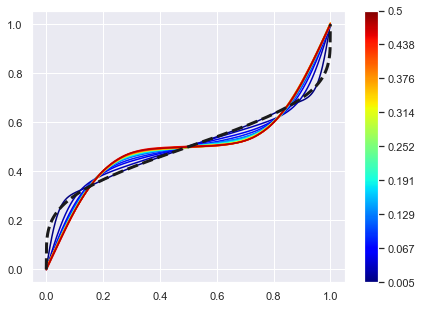

<Figure size 432x288 with 0 Axes>

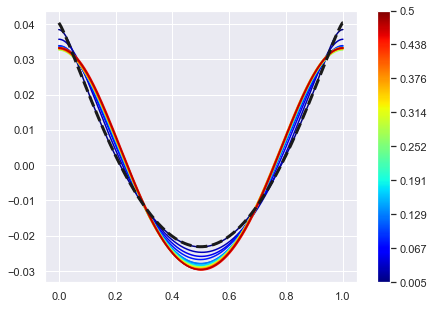

<Figure size 432x288 with 0 Axes>

In [24]:
# Choice of the colormap
normalize = mcolors.Normalize(vmin=0, vmax=nb_eps)
colormap = cm.jet
    
# ----------------------------
# Plot - Regularized quantiles
plt.figure(figsize=(7,5))

for m_eps in range(0,nb_eps):
    plt.plot(grid_x,hat_Teps[m_eps,:], color=colormap(normalize(m_eps)))

plt.plot(grid_x,T0,'--k',linewidth = 3)

# Setup the colorbar
scalarmappaple = cm.ScalarMappable(norm=normalize, cmap=colormap)
scalarmappaple.set_array(grid_eps)
cbar = plt.colorbar(scalarmappaple)
plot_grid_eps = np.round(np.linspace(0.005,0.5,9),3)
cbar.ax.set_yticklabels(plot_grid_eps)
    
# Show the figure
plt.show()

if (choix_cost == 0):
    plt.savefig('Figures/fid_1d_Teps_beta_cost_quadratic.eps',bbox_inches='tight',linewidth = 3)
else:
    plt.savefig('Figures/fid_1d_Teps_beta_cost_torus.eps',bbox_inches='tight',linewidth = 3)

# ----------------------------
# Plot - Regularized dual potentials
plt.figure(figsize=(7,5))

for m_eps in range(0,nb_eps):
    plt.plot(grid_x,hat_ueps[m_eps,:], color=colormap(normalize(m_eps)))

plt.plot(grid_x,u0,'--k',linewidth = 3)

# Setup the colorbar
scalarmappaple = cm.ScalarMappable(norm=normalize, cmap=colormap)
scalarmappaple.set_array(grid_eps)
cbar = plt.colorbar(scalarmappaple)
plot_grid_eps = np.round(np.linspace(0.005,0.5,9),3)
cbar.ax.set_yticklabels(plot_grid_eps)
    
# Show the figure
plt.show()

if (choix_cost == 0):
    plt.savefig('Figures/fid_1d_ueps_beta_cost_quadratic.eps',bbox_inches='tight',linewidth = 3)
else:
    plt.savefig('Figures/fid_1d_ueps_beta_cost_torus.eps',bbox_inches='tight',linewidth = 3)


### Then, we consider the quadratic cost

In [18]:
choix_cost = 0

The codes are exactly identical with the previous cells. Even the seed is held fixed, to ensure that the seenable differences are only caused by the change in the cost.

In [19]:
# Fixing the randomness :
random.seed(1)

# Grid for epsilon
nb_eps = 20
grid_eps = np.round(np.linspace(0.005,0.5,nb_eps),3)

# Number of iterations
n = 10**5

# Simulation of the data 
Y = beta.rvs(a, b, size=n)

hat_Teps = np.zeros([nb_eps,nb_pts])
hat_ueps = np.zeros([nb_eps,nb_pts])
hat_Weps = np.zeros([nb_eps,n])

freqs = np.fft.fftfreq(nb_pts)
    
for m_eps in range(0,nb_eps):
    
    # Choice of the regularization
    eps = grid_eps[m_eps]
    
    print('Epsilon = ', end='')
    print('{} - '.format(eps), end='')
        
    # Learning rate depending on epsilon
    gamma = eps
        
    # Compute the regularized maps by RM-FTT
    res_RM_fft = Robbins_Monro_Algo_fft(grid_x, Y, eps=eps, gamma = gamma, c = 3/4, alpha = 2, epoch = 1)
    hat_u = res_RM_fft[0][n-1]
    hat_W = res_RM_fft[1]

    hat_u_fft =np.fft.fft(hat_u)
    hat_T = grid_x - np.real(np.fft.ifft(2*np.pi*1j*freqs*hat_u_fft))/(grid_x[1]-grid_x[0])
        
    # Store the results
    hat_Teps[m_eps,:] = hat_T
    hat_ueps[m_eps,:] = hat_u 
    hat_Weps[m_eps,:] = hat_W

print(' Fin des itérations', end='\n')

Epsilon = 0.005 - Epsilon = 0.031 - Epsilon = 0.057 - Epsilon = 0.083 - Epsilon = 0.109 - Epsilon = 0.135 - Epsilon = 0.161 - Epsilon = 0.187 - Epsilon = 0.213 - Epsilon = 0.239 - Epsilon = 0.266 - Epsilon = 0.292 - Epsilon = 0.318 - Epsilon = 0.344 - Epsilon = 0.37 - Epsilon = 0.396 - Epsilon = 0.422 - Epsilon = 0.448 - Epsilon = 0.474 - Epsilon = 0.5 -  Fin des itérations


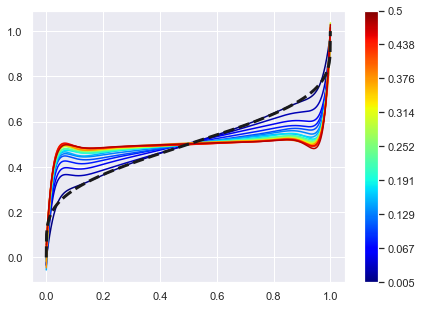

<Figure size 432x288 with 0 Axes>

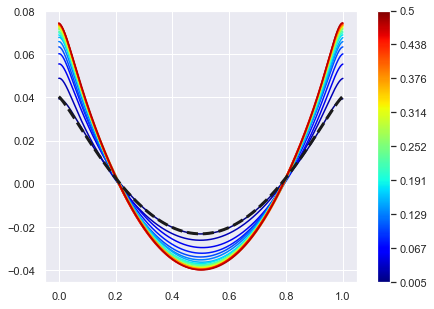

<Figure size 432x288 with 0 Axes>

In [21]:
# Choice of the colormap
normalize = mcolors.Normalize(vmin=0, vmax=nb_eps)
colormap = cm.jet
    
# ----------------------------
# Plot - Regularized quantiles
plt.figure(figsize=(7,5))

for m_eps in range(0,nb_eps):
    plt.plot(grid_x,hat_Teps[m_eps,:], color=colormap(normalize(m_eps)))

plt.plot(grid_x,T0,'--k',linewidth = 3)

# Setup the colorbar
scalarmappaple = cm.ScalarMappable(norm=normalize, cmap=colormap)
scalarmappaple.set_array(grid_eps)
cbar = plt.colorbar(scalarmappaple)
plot_grid_eps = np.round(np.linspace(0.005,0.5,9),3)
cbar.ax.set_yticklabels(plot_grid_eps)
    
# Show the figure
plt.show()

if (choix_cost == 0):
    plt.savefig('Figures/fid_1d_Teps_beta_cost_quadratic.eps',bbox_inches='tight',linewidth = 3)
else:
    plt.savefig('Figures/fid_1d_Teps_beta_cost_torus.eps',bbox_inches='tight',linewidth = 3)

# ----------------------------
# Plot - Regularized dual potentials
plt.figure(figsize=(7,5))

for m_eps in range(0,nb_eps):
    plt.plot(grid_x,hat_ueps[m_eps,:], color=colormap(normalize(m_eps)))

plt.plot(grid_x,u0,'--k',linewidth = 3)

# Setup the colorbar
scalarmappaple = cm.ScalarMappable(norm=normalize, cmap=colormap)
scalarmappaple.set_array(grid_eps)
cbar = plt.colorbar(scalarmappaple)
plot_grid_eps = np.round(np.linspace(0.005,0.5,9),3)
cbar.ax.set_yticklabels(plot_grid_eps)
    
# Show the figure
plt.show()

if (choix_cost == 0):
    plt.savefig('Figures/fid_1d_ueps_beta_cost_quadratic.eps',bbox_inches='tight',linewidth = 3)
else:
    plt.savefig('Figures/fid_1d_ueps_beta_cost_torus.eps',bbox_inches='tight',linewidth = 3)
